**Goals:**
 - Implement and test methods for extracting locations, reporting terms, reporting units, and quantities from text articles.
 - Incorporate findings from previous experiments.

In [1]:
import pandas as pd
import spacy
import os
import sys
from nltk import Tree
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from internal_displacement.pipeline import SQLArticleInterface
from itertools import groupby
from operator import itemgetter

In [2]:
nlp = spacy.load('en')

def to_nltk_tree(node):
    if node.n_lefts + node.n_rights > 0:
        return Tree(node.orth_, [to_nltk_tree(child) for child in node.children])
    else:
        return node.orth_

In [3]:
pipeline = SQLArticleInterface("../sql_db.sqlite") #Connecting to pre-populated database.
labels,features = pipeline.get_training_data()

In [210]:
class Report:
    def __init__(self,locations,date_time,event_term,subject_term,quantity,story):
        self.locations = locations
        self.date_time = date_time
        self.event_term = [t.lemma_ for t in nlp(event_term)][0]
        self.subject_term = subject_term
        self.quantity = quantity
        self.story = story
    
    def display(self):
        print("Location: {}  DateTime: {}  EventTerm: {}  SubjectTerm:  {}  Quantity: {}"
              .format(self.locations,self.date_time,self.event_term,self.subject_term,self.quantity))
        
    def show_story_tree(self):
        self.display()
        for sentence in nlp(self.story).sents:
            for token in sentence:
                if token.lemma_ == self.event_term:
                    return to_nltk_tree(sentence.root)

**Creating Ground Truth Training Examples **

In [5]:
ground_truth_reports = []

In [6]:
features[0]

"Flash flooding across Afghanistan and Pakistan has left more than 160 dead and dozens stranded in one of South Asia's worst natural disasters this year, say officials.  The flooding, caused by unusually heavy rain, has left villagers stuck in remote areas without shelter, food or power.  Mountainous Afghanistan was the worst hit, with 61 people killed and approximately 500 traditional mud-brick homes washed away in more than a dozen villages in Sarobi, a rural district less than an hour from Kabul, officials said.  Floods left a village devastated in the remote eastern Afghan province of Nuristan. At least 60 homes were destroyed across three districts, said provincial spokesman Mohammad Yusufi. No one was killed.  Authorities have been unable to deliver aid to some badly affected villages by land as roads in the area are controlled by the Taliban, Yusufi added.  “We have asked the national government for help as have an overwhelming number of locals asking for assistance, but this is

In [7]:
reports = [
    Report(["Afghanistan","Pakistan"],"this year","stranded","person","dozens",features[0]),
    Report(["Afghanistan","Pakistan"],"this year","person","dead",160,features[0]),
    Report(["Sarobi"],"","washed away","home",500,features[0]),
    Report(["Nuristan"],"","devastated","village","a",features[0]),
    Report(["Nuristan"],"","destroyed","home",60,features[0]),
    Report(["Khost","Nangarhar"],"","destroyed","home","fifty",features[0]),
    Report(["Pakistan"],"","house","collapsed","",features[0])
    ]
ground_truth_reports.extend(reports)

In [8]:
features[4]

'Afghanistan state news agency, Bakhtar News Agency (BNA) report that at least 7 people have been killed in flash floods in Faryab Province in the north of the country. Flash floods in Baghlan Province have killed 1 person and injured around 10 others.  Flash floods struck on 08 May 2015 in Faryab Province after a period of heavy rainfall. The districts of Garyzan, Pashtunkot and Belcheragh were worst affected. BNA report that at least 7 people were killed and over 1,500 homes damaged. The Faizabada-Takhar highway have been closed to traffic and wide areas of crops and orchards have suffered damaged.  Kuwaiti News Agency (KUNA) also report that flooding struck in the Baghlan-i-Markazi district of Baghlan province, where 1 person was killed and several injured early on Saturday 09 May 2015.  “There was heavy rain in Baghlan-e-Markazi district Friday evening and the people left their houses to safer areas. It was early Saturday when a flash flood hit the area and washed away more than 50

In [9]:
reports = [
    Report(["Faryab Province"],"","killed","people",7,features[4]),
    Report(["Garyzan","Pashtunkot","Belcheragh"],"","damaged","home",1500,features[4]),
    Report(["Garyzan","Pashtunkot","Belcheragh"],"","killed","people",7,features[4]),
    Report(["Baghlan-e-Markazi"],"Saturday 09 May 2015","killed","person",1,features[4]),
    Report(["Baghlan-e-Markazi"],"Saturday 09 May 2015","injured","person","several",features[4]),
    Report(["Baghlan-e-Markazi"],"Saturday","washed_away","house",500,features[4])
]
ground_truth_reports.extend(reports)

**Defining Reporting Terms**

In [254]:
person_reporting_terms = [
    'displaced', 'evacuated', 'forced flee', 'homeless', 'relief camp',
    'sheltered', 'relocated', 'stranded','stuck','stranded',"killed","dead","died"
]

structure_reporting_terms = [
    'destroyed','damaged','swept','collapsed','flooded','washed'
]

person_reporting_units = ["families","person","people","individuals","locals","villagers","residents","occupants","citizens"]

structure_reporting_units = ["home","house","hut","dwelling","building","shop","business","apartment","flat"]


person_term_lemmas = [t.lemma_ for t in nlp(" ".join(person_reporting_terms))]
structure_term_lemmas = [t.lemma_ for t in nlp(" ".join(structure_reporting_terms))]
person_unit_lemmas = [t.lemma_ for t in nlp(" ".join(person_reporting_units))]
structure_unit_lemmas = [t.lemma_ for t in nlp(" ".join(structure_reporting_units))]

reporting_term_lemmas = person_term_lemmas + structure_term_lemmas
reporting_unit_lemmas = person_unit_lemmas + structure_unit_lemmas

**Checking the spacy NER system performance for location detection**

In [11]:
def spacy_locations_from_text(text):
    locations = []
    smodel = nlp(text)
    for ent in smodel.ents:
        if ent.label_ == "GPE":
            locations.append(ent.text)
    return locations

In [12]:
missed_locations = []
for g in ground_truth_reports:
    spacy_locs = spacy_locations_from_text(g.story)
    print(spacy_locs)
    print(g.locations)
    for g in g.locations:
        if g not in spacy_locs:
            missed_locations.append(g)
    print("=====")
print("Ground Truth Locations Missed by spacy: {}".format(missed_locations))    

['Afghanistan', 'Pakistan', 'Afghanistan', 'Sarobi', 'Kabul', 'Nuristan', 'Khost', 'Nangarhar', 'Pakistan', 'Karachi']
['Afghanistan', 'Pakistan']
=====
['Afghanistan', 'Pakistan', 'Afghanistan', 'Sarobi', 'Kabul', 'Nuristan', 'Khost', 'Nangarhar', 'Pakistan', 'Karachi']
['Afghanistan', 'Pakistan']
=====
['Afghanistan', 'Pakistan', 'Afghanistan', 'Sarobi', 'Kabul', 'Nuristan', 'Khost', 'Nangarhar', 'Pakistan', 'Karachi']
['Sarobi']
=====
['Afghanistan', 'Pakistan', 'Afghanistan', 'Sarobi', 'Kabul', 'Nuristan', 'Khost', 'Nangarhar', 'Pakistan', 'Karachi']
['Nuristan']
=====
['Afghanistan', 'Pakistan', 'Afghanistan', 'Sarobi', 'Kabul', 'Nuristan', 'Khost', 'Nangarhar', 'Pakistan', 'Karachi']
['Nuristan']
=====
['Afghanistan', 'Pakistan', 'Afghanistan', 'Sarobi', 'Kabul', 'Nuristan', 'Khost', 'Nangarhar', 'Pakistan', 'Karachi']
['Khost', 'Nangarhar']
=====
['Afghanistan', 'Pakistan', 'Afghanistan', 'Sarobi', 'Kabul', 'Nuristan', 'Khost', 'Nangarhar', 'Pakistan', 'Karachi']
['Pakistan']
==

Spacy appears to be doing a good job of detecting place names. The spacy language model can always be trained with new data if it is found to make a mistake in the future.

** Generating Reports with Locations **
There are frequently multiple locations present within a document, but not all of these locations will apply to each Report.

In [110]:
def get_descendents(sentence,root=None):
    """
    Retrieves all tokens that are descended from the head of the specified root token.
    param: root: the root token
    param: sentence: a span from which to retrieve tokens.
    returns: a list of tokens
    """
    if not root:
        root = sentence.root
    else:
        root = root.head
    return [t for t in sentence if root.is_ancestor_of(t)]
    
def check_if_entity_contains_token(tokens,entity):
    """
    Function to test if a given entity contains at least one of a list of tokens.
    param: tokens: A list of tokens
    param: entity: A span
    
    returns: Boolean
    """
    tokens_ = [t.text for t in tokens]
    ret = False
    for token in entity:
        if token.text in tokens_:
            return True
    return False


    

testing_document = nlp("Flooding in Zimbabwe, South Africa, and China has caused chaos. I am lucky to be in Australia, since there has been havoc in Iceland, South Africa and New Zealand, an island nation south east of Melbourne")
testing_sentences = list(testing_document.sents)

havoc_test_2_token = [t for t in testing_sentences[1] if t.text =="havoc" ][0]
lower_tokens2 = get_descendents(testing_sentences[1],havoc_test_2_token)
lower_token_texts2 = [ t.text for t in lower_tokens2]
assert lower_token_texts2 == ['since', 'there', 'has', 'havoc', 'in', 'Iceland', ',', 'South', 'Africa', 'and', 'New', 'Zealand', ',', 'an', 'island','nation', 'south', 'east', 'of', 'Melbourne']


testing_location_entities = [ e for e in  testing_document.ents if e.label_ =="GPE"]
assert check_if_entity_contains_token(lower_tokens2,testing_location_entities[-1])
assert check_if_entity_contains_token(lower_tokens2,testing_location_entities[-2])
assert check_if_entity_contains_token(lower_tokens2,testing_location_entities[-3])
assert check_if_entity_contains_token(lower_tokens2,testing_location_entities[-4])
assert not check_if_entity_contains_token(lower_tokens2,testing_location_entities[3])

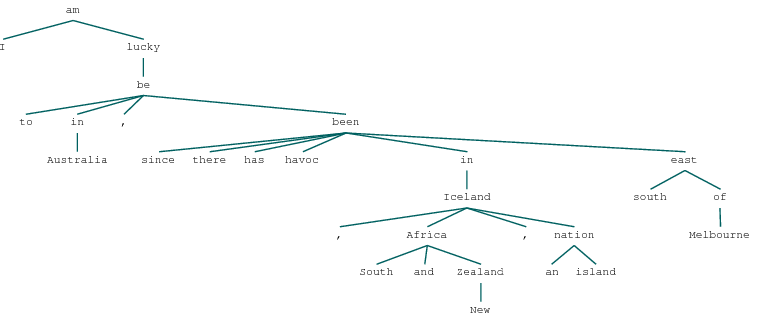

In [113]:
to_nltk_tree(testing_sentences[1].root)

In [225]:
def test_token_equality(token_a,token_b):
    if token_a.text == token_b.text:
        return True
    else:
        return False
def check_if_collection_contains_token(token,collection):
    if any([test_token_equality(token,t) for t in collection]):
        return True
    else:
        return False

def get_distance_from_root(token,root):
    """
    Gets the parse tree distance between a token and the sentence root.
    :param token: a token
    :param root: the root token of the sentence
    
    returns: an integer distance
    """
    if token == root:
        return 0
    d = 1
    p = token.head
    while p is not root:
        d+=1
        p = p.head
    return d

assert get_distance_from_root(testing_sentences[1].root,testing_sentences[1].root) == 0
assert get_distance_from_root(testing_sentences[1][6],testing_sentences[1].root) == 4
assert get_distance_from_root(testing_sentences[1][-1],testing_sentences[1].root) == 6

def get_common_ancestors(tokens):
    ancestors = [set(t.ancestors) for t in tokens]
    if len(ancestors) == 0:
        return []
    common_ancestors = ancestors[0].intersection(*ancestors)
    return common_ancestors
    

def get_contiguous_tokens(token_list):
    common_ancestor_tokens = get_common_ancestors(token_list)
    highest_contiguous_block = []
    for toke in token_list:
        if check_if_collection_contains_token(toke.head,common_ancestor_tokens):
            highest_contiguous_block.append(toke)
    added_tokens = 1
    while added_tokens > 0:
        added_tokens = 0
        for toke in token_list:
            if check_if_collection_contains_token(toke.head,highest_contiguous_block):
                if not check_if_collection_contains_token(toke,highest_contiguous_block):
                    highest_contiguous_block.append(toke)
                    added_tokens +=1
    return highest_contiguous_block

def match_entities_in_block(entities,token_block):
    matched = []
    text_block = [t.text for t in token_block] #For some reason comparing identity on tokens does not always work.
    for e in entities:
        et = [t.text for t in e]
        et_in_b = [t for t in et if t in text_block]
        if len(et_in_b) == len(et):
            matched.append(e)
    return matched

test_tokes = [t for t in testing_sentences[1]]
assert test_token_equality(test_tokes[5],test_tokes[5])
assert not test_token_equality(test_tokes[5],test_tokes[3])

assert check_if_collection_contains_token(test_tokes[5],test_tokes)
assert not check_if_collection_contains_token(test_tokes[-1],test_tokes[:-2])

In [226]:
def extract_locations(sentence,root=None):
    """
    Examines a sentence and identifies if any of its constituent tokens describe a location.
    If a root token is specified, only location tokens below the level of this token in the tree will be examined. 
    If no root is specified, location tokens will be drawn from the entirety of the span.
    param: sentence       a span
    param: root           a token
    returns: A list of strings, or None
    """
    if not root:
        root = sentence.root
    descendents = get_descendents(sentence,root)
    location_entities = [e for e in nlp(sentence.text).ents if e.label_ == "GPE"]
    if len(location_entities) > 0:
        descendent_location_tokens = []
        for location_ent in location_entities:
            if check_if_entity_contains_token(location_ent,descendents):
                descendent_location_tokens.extend([token for token in location_ent])
        contiguous_token_block = get_contiguous_tokens(descendent_location_tokens)

        block_locations = match_entities_in_block(location_entities,contiguous_token_block)
        return [location.text for location in block_locations]
    else:
        return []

In [191]:
assert extract_locations(testing_sentences[1],havoc_test_2_token) == ['Iceland', 'South Africa', 'New Zealand']

In [192]:
block = get_contiguous_tokens(location_tokens)
block

[]

In [193]:
extract_locations(testing_sentences[1],havoc_test_2_token)

['Iceland', 'South Africa', 'New Zealand']

In [195]:
test_sent2 = list(nlp(features[0]).sents)[2]
test_sent2_term = [t for t in test_sent2 if t.text =="washed"][0]
assert extract_locations(test_sent2,test_sent2_term) == ["Sarobi"]

In [251]:

def find_reports(story):
    reports = []
    sentences = list(nlp(story).sents)
    for i,sentence in enumerate(sentences):
        for token in sentence:
            if token.lemma_ in reporting_term_lemmas:
                term_token = token
                children = term_token.children
                unit_children = list(filter(lambda x: x.lemma_ in reporting_unit_lemmas,children))
                possible_locations = extract_locations(sentence,token)
                if len(possible_locations) == 0:
                    if i > 0:
                        possible_locations = extract_locations(sentences[i-1])
                for uc in unit_children:
                    uc_children = uc.children
                    for token in uc_children:
                        if token.like_num:
                            number = token.text
                            reporting_unit = uc.text
                            reporting_term = term_token.text
                            report = Report(possible_locations,"",reporting_term,reporting_unit,number,story)
                            reports.append(report)
                            report.display()
                
                
            
    return reports

In [221]:
features[0]

"Flash flooding across Afghanistan and Pakistan has left more than 160 dead and dozens stranded in one of South Asia's worst natural disasters this year, say officials.  The flooding, caused by unusually heavy rain, has left villagers stuck in remote areas without shelter, food or power.  Mountainous Afghanistan was the worst hit, with 61 people killed and approximately 500 traditional mud-brick homes washed away in more than a dozen villages in Sarobi, a rural district less than an hour from Kabul, officials said.  Floods left a village devastated in the remote eastern Afghan province of Nuristan. At least 60 homes were destroyed across three districts, said provincial spokesman Mohammad Yusufi. No one was killed.  Authorities have been unable to deliver aid to some badly affected villages by land as roads in the area are controlled by the Taliban, Yusufi added.  “We have asked the national government for help as have an overwhelming number of locals asking for assistance, but this is

In [238]:
features[5]

'ALGIERS (AA) – Hundreds of homes have been destroyed in Algeria‘s southern city of Tamanrasset following several days of torrential rainfall, a local humanitarian aid official said Wednesday.  The city was pounded by rainfall from March 19 to March 24, according to Ghanom Sudani, a member of a government-appointed humanitarian aid committee.  He added that heavy rains had destroyed as many as 400 residences.  “Hundreds of families have had to leave their homes after they were inundated with water,” Sudani told The Anadolu Agency.  www.aa.com.tr/en  Last month neighbouring Tunisia experienced heavy rainfall and flooding in Jendouba City.'

In [237]:
find_reports(features[5])

[]

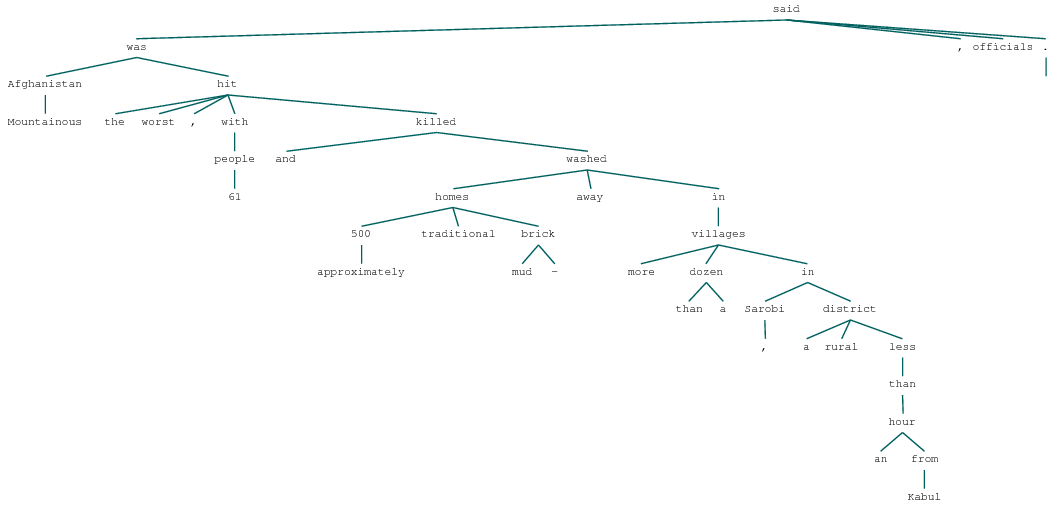

In [134]:
to_nltk_tree(list(nlp(features[0]).sents)[2].root)

In [247]:
features[5]

'ALGIERS (AA) – Hundreds of homes have been destroyed in Algeria‘s southern city of Tamanrasset following several days of torrential rainfall, a local humanitarian aid official said Wednesday.  The city was pounded by rainfall from March 19 to March 24, according to Ghanom Sudani, a member of a government-appointed humanitarian aid committee.  He added that heavy rains had destroyed as many as 400 residences.  “Hundreds of families have had to leave their homes after they were inundated with water,” Sudani told The Anadolu Agency.  www.aa.com.tr/en  Last month neighbouring Tunisia experienced heavy rainfall and flooding in Jendouba City.'

In [241]:
test = [t for t in nlp(features[5]) if t.text == "Hundreds"]
for t in test:
    print(t,t.like_num)

Hundreds False
Hundreds False


In [255]:
for s in features[:100]:
    print("=============Story================")
    print(s)
    print("=============Reports================")
    find_reports(s)

=============Story================
Flash flooding across Afghanistan and Pakistan has left more than 160 dead and dozens stranded in one of South Asia's worst natural disasters this year, say officials.  The flooding, caused by unusually heavy rain, has left villagers stuck in remote areas without shelter, food or power.  Mountainous Afghanistan was the worst hit, with 61 people killed and approximately 500 traditional mud-brick homes washed away in more than a dozen villages in Sarobi, a rural district less than an hour from Kabul, officials said.  Floods left a village devastated in the remote eastern Afghan province of Nuristan. At least 60 homes were destroyed across three districts, said provincial spokesman Mohammad Yusufi. No one was killed.  Authorities have been unable to deliver aid to some badly affected villages by land as roads in the area are controlled by the Taliban, Yusufi added.  “We have asked the national government for help as have an overwhelming number of locals 